In [1]:
import os
import multiprocessing as mp

import cv2
import glob2
import pydicom
from tqdm import tqdm
import zipfile
import io
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import exposure

import sys
sys.path.insert(0, '../../data/siim-pneumothorax')
from mask_functions import *

In [2]:
tag = 's2'
#sz = 1024
sz0 = 1024

data_root = '../../data/siim-pneumothorax'

# we'll create masks for stage-1 testset
PATH_TEST_S1 = os.path.join(data_root, 'dicom-images-test/')
# we'll export png from stage-2 testset
PATH_TEST_S2 = os.path.join(data_root, 'dicom-images-test-s2/')

test_out = os.path.join(data_root, 'test_s2_{}.zip'.format(tag))
mask_out = os.path.join(data_root, 'masks_s1_{}.zip'.format(tag))

test_s1 = glob2.glob(os.path.join(PATH_TEST_S1, '**/*.dcm'))
test_s2 = glob2.glob(os.path.join(PATH_TEST_S2, '**/*.dcm'))

In [3]:
# get all train indexes
df = pd.read_csv(os.path.join(data_root, 'stage_2_train.csv')).set_index('ImageId')
idxs = set(df.index)

# get positive ids of stage-1 testset
'''
test_s1_names = []

for f in test_s1: #remove images without labels
    name = f.split('/')[-1][:-4]
    if name in idxs: test_s1_names.append(f)
'''

"\ntest_s1_names = []\n\nfor f in test_s1: #remove images without labels\n    name = f.split('/')[-1][:-4]\n    if name in idxs: test_s1_names.append(f)\n"

In [4]:
def convert_images(filename, arch_out):
    # read dicom
    ds = pydicom.read_file(str(filename))
    img = ds.pixel_array.astype(np.float)
    
    img = (img / 255.).astype(np.float)
    #img = cv2.resize(img, (sz, sz))
    #img = exposure.equalize_adapthist(img) # contrast correction
    
    # stat
    x_tot = img.mean() #image statistics
    x2_tot = (img**2).mean()
    
    # convert
    img = ((img*255)).clip(0,255).astype(np.uint8)
    output = cv2.imencode('.png',img)[1]
    name = filename.split('/')[-1][:-4] + '.png'
    
    # export
    arch_out.writestr(name, output)
    
    return x_tot, x2_tot

def get_stats(stats): # get dataset statistics 
    x_tot, x2_tot = 0.0, 0.0
    for x, x2 in stats:
        x_tot += x
        x2_tot += x2
    
    img_avr =  x_tot/len(stats)
    img_std =  np.sqrt(x2_tot/len(stats) - img_avr**2)
    
    print('mean:',img_avr, ', std:', img_std)


In [5]:
# convert png from stage-2 testset
test_stats = []        
with zipfile.ZipFile(test_out, 'w') as arch:
    for fname in tqdm(test_s2, total=len(test_s2), file=sys.stdout):
        test_stats.append(convert_images(fname,arch))

100%|██████████| 3205/3205 [01:25<00:00, 37.73it/s]


In [6]:
get_stats(test_stats)

mean: 0.48873194751901095 , std: 0.25010293109952697


In [7]:
# create masks for stage-1 testset
mask_coverage = []
mask_count = 0

with zipfile.ZipFile(mask_out, 'w') as arch:
    for idx in tqdm(idxs):
        # read mask
        masks = df.loc[idx,'EncodedPixels']
        img = np.zeros((sz0, sz0))
        
        #do conversion if mask is not " -1"
        if(type(masks) != str or (type(masks) == str and masks != '-1')):
            if(type(masks) == str): masks = [masks]
            else: masks = masks.tolist()
            
            mask_count +=1
            
            for mask in masks:
                img += rle2mask(mask, sz0, sz0).T
                
        mask_coverage.append(img.mean())
        
        #img = cv2.resize(img, (sz, sz))
        output = cv2.imencode('.png', img)[1]
        name = idx + '.png'
        
        arch.writestr(name, output)

print('mask coverage:', np.mean(mask_coverage)/255, ', mask count:', mask_count)

100%|██████████| 12047/12047 [00:54<00:00, 219.24it/s]


mask coverage: 0.003145134853724969 , mask count: 2669


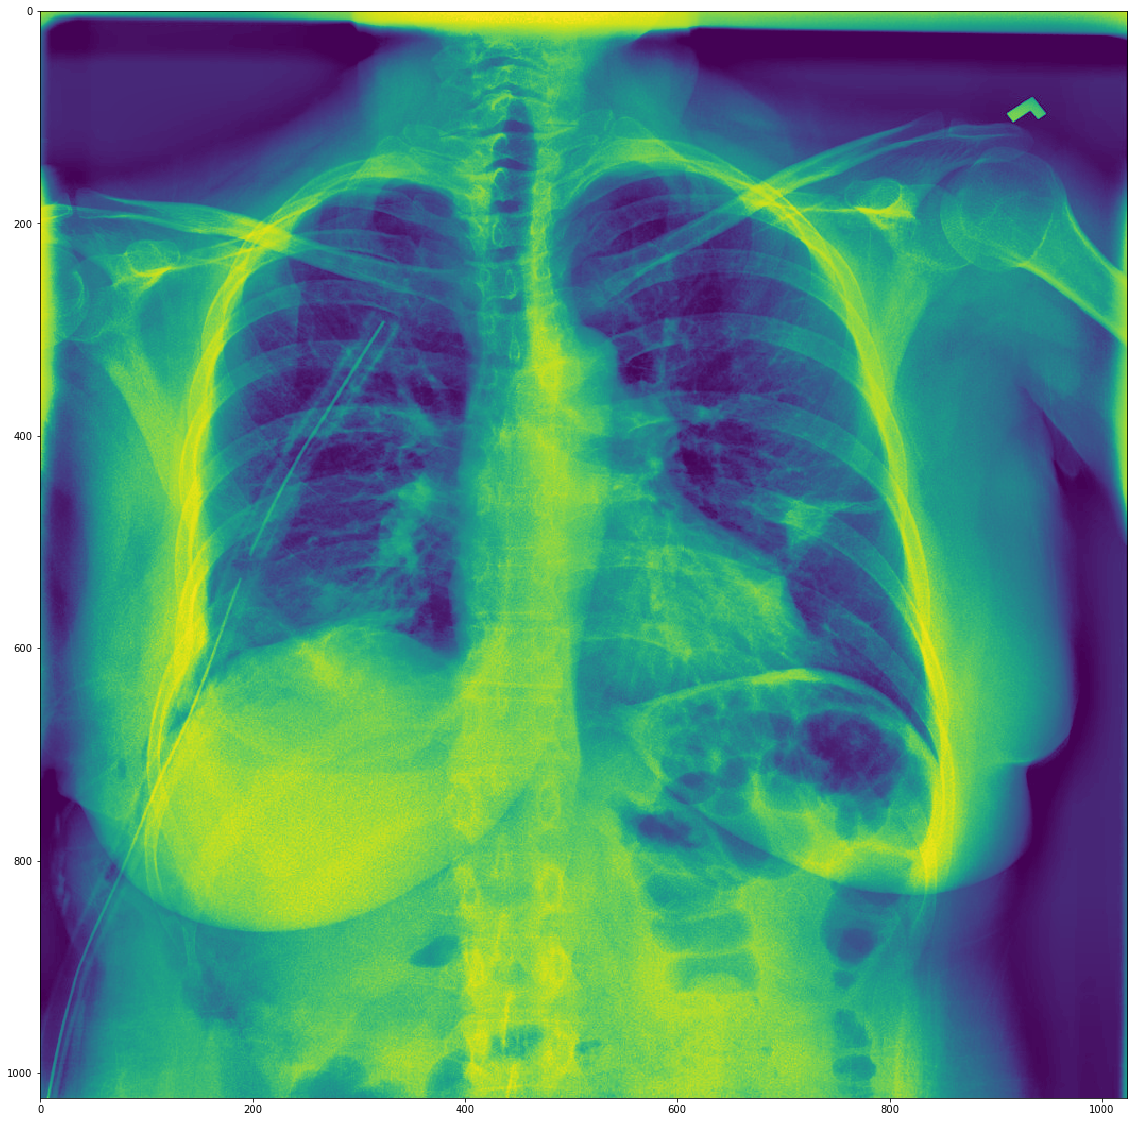

In [23]:
idx = 6
with zipfile.ZipFile(os.path.join(data_root, 'train_1024.zip'), 'r') as arch:
    fname = sorted(arch.namelist())[idx]
    flags = cv2.IMREAD_GRAYSCALE
    img = cv2.imdecode(np.frombuffer(arch.read(fname), np.uint8), flags)
    
with zipfile.ZipFile(mask_out, 'r') as arch:
    fname = sorted(arch.namelist())[idx]
    flags = cv2.IMREAD_GRAYSCALE
    mask = cv2.imdecode(np.frombuffer(arch.read(fname), np.uint8), flags)
    
plt.figure(figsize=(40,20))
plt.imshow(Image.fromarray(img))
#plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()